In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [10]:
# Step 1: Data Preprocessing
def load_and_preprocess_data():
    df = pd.read_csv('medical_insurance.csv')
    
    # Check for missing, duplicates, inconsistencies
    print("Missing values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())
    df.drop_duplicates(inplace=True)
    
    # Feature engineering: BMI classification
    def bmi_category(bmi):
        if bmi < 18.5:
            return 'underweight'
        elif 18.5 <= bmi < 25:
            return 'normal'
        elif 25 <= bmi < 30:
            return 'overweight'
        else:
            return 'obese'
    
    df['bmi_category'] = df['bmi'].apply(bmi_category)
    
    # Interaction term: age * smoker (encode smoker temporarily)
    df['smoker_encoded'] = df['smoker'].map({'yes': 1, 'no': 0})
    df['age_smoker_interaction'] = df['age'] * df['smoker_encoded']
    
    return df

In [11]:
# Step 2: EDA
def perform_eda(df):
    # Key factors: correlations
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    print("Correlations:\n", corr['charges'].sort_values(ascending=False))
    
    # Plots
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='smoker', y='charges', data=df)
    plt.title('Impact of Smoking on Charges')
    plt.savefig('smoker_charges.png')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='age', y='charges', hue='smoker', data=df)
    plt.title('Impact of Age on Charges by Smoker Status')
    plt.savefig('age_charges.png')
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='region', y='charges', data=df)
    plt.title('Charges by Region')
    plt.savefig('region_charges.png')

In [12]:
# Step 3: Model training
def train_and_evaluate_models(df):
    results = {}
    try:
        X = df.drop(['charges', 'smoker_encoded'], axis=1)
        y = df['charges']

        categorical_features = ['sex', 'smoker', 'region', 'bmi_category']
        numeric_features = ['age', 'bmi', 'children', 'age_smoker_interaction']

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
                ('num', 'passthrough', numeric_features)
            ]
        )

        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42),
            'XGBoost': XGBRegressor(random_state=42, n_estimators=100)
        }

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        for name, model in models.items():
            try:
                print(f"\nTraining {name}...")
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
                print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

            except Exception as e:
                print(f"Error training {name}: {e}")
                traceback.print_exc()

        # Only proceed if we have results
        if not results:
            print("No models trained successfully.")
            return None

        # Select best
        best_model_name = max(results, key=lambda x: results[x]['R2'])
        print(f"\nBest model: {best_model_name} (R² = {results[best_model_name]['R2']:.3f})")

        # Retrain on full data
        best_model = models[best_model_name]
        final_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', best_model)
        ])
        final_pipeline.fit(X, y)
        joblib.dump(final_pipeline, 'best_model.pkl')
        print("Best model saved as 'best_model.pkl'")

        return results

    except Exception as e:
        print("Critical error in model training:", e)
        traceback.print_exc()
        return None

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Duplicates: 1435
Correlations:
 charges                   1.000000
age_smoker_interaction    0.789253
smoker_encoded            0.787234
age                       0.298308
bmi                       0.198401
children                  0.067389
Name: charges, dtype: float64

Training Linear Regression...
Linear Regression - RMSE: 6008.14, MAE: 4328.37, R2: 0.804

Training Ridge Regression...
Ridge Regression - RMSE: 6002.78, MAE: 4325.67, R2: 0.804

Training Random Forest...
Random Forest - RMSE: 4676.98, MAE: 2622.86, R2: 0.881

Training Gradient Boosting...
Gradient Boosting - RMSE: 4189.37, MAE: 2442.63, R2: 0.904

Training XGBoost...
XGBoost - RMSE: 5115.21, MAE: 2958.03, R2: 0.858

Best model: Gradient Boosting (R² = 0.904)
Best model saved as 'best_model.pkl'


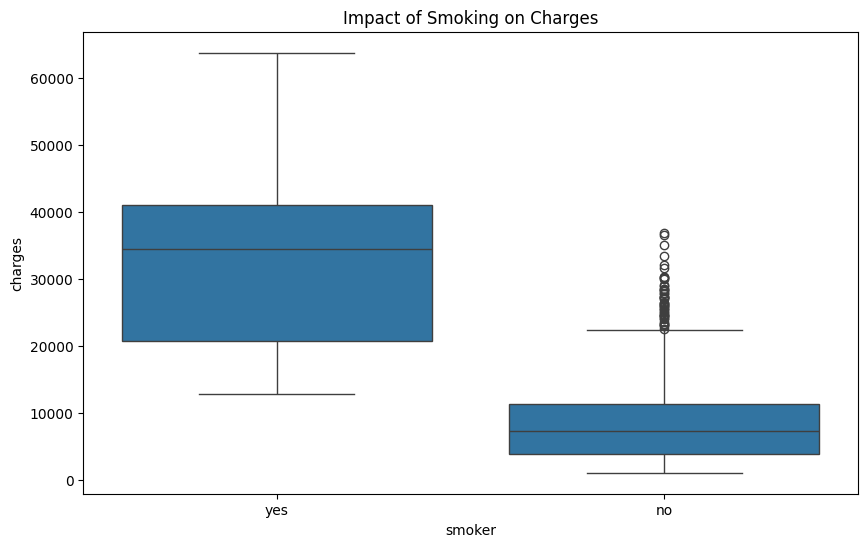

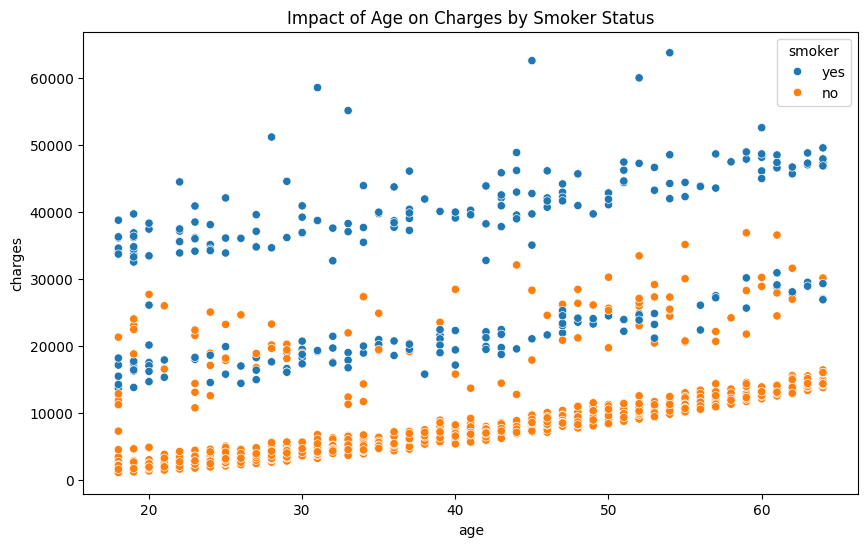

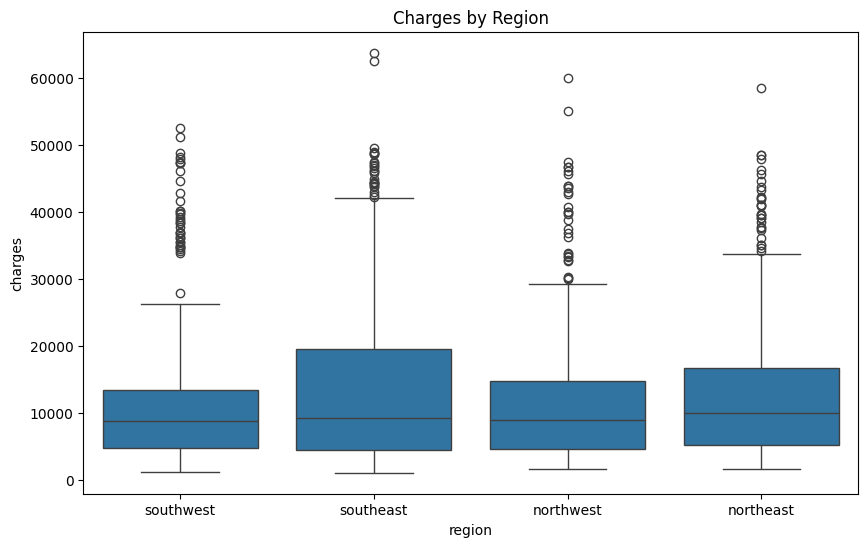

In [14]:
if __name__ == "__main__":
    df = load_and_preprocess_data()
    perform_eda(df)
    results = train_and_evaluate_models(df)